# MOCpy tutorial ROSA 2022

Stefania Amodeo¹, Katharina A. Lutz¹

1. Université de Strasbourg, CNRS, Observatoire Astronomique de Strasbourg, UMR 7550, F-67000, Strasbourg, France

This tutorial was conceived by Stefania Amodeo based on previous notebooks written by Katarina A. Lutz. It was presented for the online workshop for Reproducibility and Open Sicence in Astronomy ([ROSA](https://www.eso.org/sci/meetings/2022/REPRODUCIBILITY2022.html)) in May 2022.

***

## Introduction

This tutorial aims to demontrate the use of FAIR data with Multi-Order Coverage maps ([MOC](https://www.ivoa.net/documents/MOC/)). MOCs are an International Virtual Observatory Alliance ([IVOA](https://ivoa.net/)) standard to describe sky region of arbitrary shape and positions. They are based on the Hierarchical Equal Area isoLatitude Pixelization ([HEALPix](https://iopscience.iop.org/article/10.1086/427976/meta)). 

Among other uses of MOC maps, we will cover functionnalities of the [MOCpy library](https://cds-astro.github.io/mocpy/) here:
- the footprints of surveys, 
- the generation of arbitrary polygons from a list of sky coordinates
- the visualisation and use of sky coverages of catalogs
- space and time coverage with STMOCs
- fast logical operations (intersection, union, difference) between MOCs.

In [1]:
# General python packages
from pathlib import Path

# Findind and access data
from astroquery.cds import cds
from astroquery.simbad import Simbad
import pyvo

# Working with MOCs
from mocpy import STMOC
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from astropy import units as u

# Visualization
from mocpy import World2ScreenMPL
import ipyaladin.aladin_widget as ipyal
import matplotlib.pyplot as plt

## Query the Strasbourg astronomical Data Center (CDS) for spatial footprints (MOCs)

We use the module `astroquery.cds` to query the [CDS MOCServer](http://alasky.unistra.fr/MocServer/query) to retrieve data-sets based on their meta data values.

In [2]:
info_1 = cds.find_datasets(meta_data="ID=*SDSS*")
print(info_1['ID']) 

info_2 = cds.find_datasets(meta_data="ID=*XMM*")
print(info_2['ID']) 

            ID           
-------------------------
CDS/J/ApJ/749/10/SDSS-obs
          CDS/P/HLA/SDSSg
          CDS/P/HLA/SDSSr
          CDS/P/HLA/SDSSz
          CDS/P/HST/SDSSg
          CDS/P/HST/SDSSr
          CDS/P/HST/SDSSz
        CDS/P/SDSS9/color
    CDS/P/SDSS9/color-alt
            CDS/P/SDSS9/g
            CDS/P/SDSS9/i
            CDS/P/SDSS9/r
            CDS/P/SDSS9/u
            CDS/P/SDSS9/z
           ID          
-----------------------
   ESAVO/P/XMM/EPIC-RGB
 ESAVO/P/XMM/OM-Optical
      ESAVO/P/XMM/OM-UV
JAXA/XMM/EPIC/Catalogue
  xcatdb/P/XMM/PN/color
    xcatdb/P/XMM/PN/eb2
    xcatdb/P/XMM/PN/eb3
    xcatdb/P/XMM/PN/eb4


#### Get the MOC object corresponding to the <ins>union</ins> of the MOCs from all the retrieved data-sets

In [3]:
moc_sdss = cds.find_datasets(meta_data="ID=CDS/P/SDSS9/color*", return_moc=True)
moc_xmm = cds.find_datasets(meta_data="ID=ESAVO/P/XMM/EPIC-RGB", return_moc=True)

#### Is a given source observed by a specific survey? 

In [4]:
m87 = Simbad.query_object('M87')
m87

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
M 87,12 30 49.4233,+12 23 28.043,12,12,0.041,0.043,90,A,R,2015AJ....150...58F,1


In [5]:
ra, dec = Angle('12h30m49.4233s'), Angle('12d23m28.043s')

print(moc_xmm.contains(ra, dec))

[ True]


## Compute the intersection of the MOCs
What fraction of the sky is covered by both SDSS and XMM ?

In [6]:
moc_intersection = moc_sdss.intersection(moc_xmm)

sky_frac = moc_intersection.sky_fraction
print(f'The intersection of SDSS and XMM covers {round(sky_frac * 100., 1)} % of the sky')

The intersection of SDSS and XMM covers 3.9 % of the sky


## Save into a fits file

In [7]:
moc_intersection.serialize(format='fits')
moc_intersection.save("moc_intersection.fits", format="fits", overwrite=True)

## Visualize and interact with MOCs in Aladin Lite using `ipyaladin`

In [8]:
aladin = ipyal.Aladin(target='M87', survey='P/SDSS9/color')
aladin

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

In [9]:
aladin.add_moc_from_dict(moc_sdss.serialize(format='json'), {'color': 'yellow', 'opacity': 0.3, 'name': 'SDSS'})
aladin.add_moc_from_dict(moc_xmm.serialize(format='json'), {'color': 'blue', 'opacity': 0.5, 'name': 'XMM'})
aladin.add_moc_from_dict(moc_intersection.serialize(format='json'), {'color': 'magenta', 'opacity': 0.5, 'name': 'intersection'})

## Filter a table by a MOC

I have a catalogue of sources, how I can select those observed in SDSS and with XMM?

In [10]:
tap_vizier = pyvo.dal.TAPService('https://tapvizier.cds.unistra.fr/TAPVizieR/tap')

query = """SELECT  *  FROM "VII/192/arplist" """

table_arplist = tap_vizier.search(query).to_table()
table_arplist.show_in_notebook(display_length=5)

idx,recno,Arp,Name,VT,u_VT,dim1,dim2,u_dim2,MType,Uchart,RAJ2000,DEJ2000
,,,,mag,,arcmin,arcmin,,,,deg,deg
0,112,333,NGC 1024,12.1,,3.9,1.4,,(R')SA(r)ab,175,39.80083333333333,10.847222222222221
1,120,200,NGC 1134,12.1,,2.5,0.9,,S?,175,43.42124999999999,13.015277777777776
2,119,190,UGC 02320,15.2,,0.5,0.3,,Multiple Sys,--,42.58291666666666,12.889444444444443
3,89,290,IC 0195,14.3,,1.6,0.8,,S0,--,30.935833333333328,14.708611111111109
4,90,290,IC 0196,14.2,,2.8,1.4,,S0-,--,30.95833333333333,14.73972222222222
5,111,258,UGC 02140A,15.5,,0.9,0.2,,SB.0*/,--,39.78874999999999,18.367499999999996
6,110,258,UGC 02140,15.4,,1.7,0.7,,IBS9P,--,39.77583333333333,18.382777777777775
7,109,258,Hickson 18C,16.1,,--,--,,S?,--,39.774583333333325,18.388333333333332
8,108,258,Hickson 18D,14.6,,--,--,,S?,--,39.76916666666666,18.393888888888885


In [11]:
coords = SkyCoord(ra=table_arplist['RAJ2000'], 
                  dec=table_arplist['DEJ2000'], 
                  unit=(u.deg, u.deg))

indexes = moc_intersection.contains(coords.ra, 
                                    coords.dec)

print(f'{len(table_arplist[indexes])} peculiar galaxies are observed both by SDSS and XMM')

164 peculiar galaxies are observed both by SDSS and XMM


In [12]:
aladin.add_table(table_arplist[indexes]['Name', 'RAJ2000', 'DEJ2000'])

## 2. Space & Time coverage: STMOC

In [13]:
# Find catalog on Vizier 
tap_vizier = pyvo.dal.TAPService('https://tapvizier.cds.unistra.fr/TAPVizieR/tap')

query = """
SELECT *  FROM tables
WHERE description LIKE '%SDSS%quasar%catalog%'
"""

sdss_catalogues = tap_vizier.search(query).to_table()
sdss_catalogues

schema_name,table_name,table_type,description,utype,nrows
object,object,object,object,object,object
J_ApJ,J/ApJ/679/962/table1,table,"SDSS DR5 N-rich quasar catalog ( Jiang L., Fan X., Vestergaard M.)",,293
J_ApJS,J/ApJS/201/10/table8,table,"SDSS quasar catalog with Swift observations ( Wu J., Vanden Berk D., Grupe D., Koch S., Gelbord J., Schneider D.P., Gronwall C., Wesolowski S., Porterfield B.L.)",,1034
VII_nonstellar,VII/243/dr3qso,table,"The SDSS quasar catalog III ( Schneider D.P., Hall P.B., Richards G.T., et al.)",,46420
J_ApJS,J/ApJS/258/38/table2,table,"Test from the SDSS DR7 quasar catalog ( Park D., Barth A.J., Ho L.C., Laor A.)",,41
VII_nonstellar,VII/289/dr16q,table,"The SDSS quasar-only catalog from DR16 (DR16Q) ( Lyke B.W., Higley A.N., McLane J.N., et al.)",,750414
J_MNRAS,J/MNRAS/397/1713/fsrq,table,"Flat-spectrum radio quasars from the SDSS DR3 quasar catalogue ( Chen Z., Gu M., Cao X.)",,185
VII_nonstellar,VII/286/dr14q,table,"Final SDSS-DR14 quasar catalog ( Paris I., Petitjean P., Aubourg E., et al.)",,526356
J_ApJS,J/ApJS/244/36/table1,table,"SDSS-IV/eBOSS quasar catalog ( Chen Z.-F., Yi S.-X., Pang T.-T., Chen Z.-G., Gui R.-J., Wang Z.-W., Mo X.-H., Yi T.-F.)",,173935
VII_nonstellar,VII/260/dr7qso,table,"The SDSS quasar catalog V, DR7 (table2 of the paper) ( Schneider D.P., Richards G.T., Hall P.B., et al.)",,105783


In [14]:
# Access the catalog 
# Check the first rows to explore the table content and columns

query = """SELECT 
TOP 3 *
FROM "VII/286/dr14q" """

table_info = tap_vizier.search(query).to_table()
table_info

recno,SDSS,SDSSo,RAJ2000,DEJ2000,THINGID,Plate,MJD,Fiber,Note,z,r_z,z_v,z_b,e_z_b,f_z_b,z_PCA,e_z_PCA,zMgII,Btarg1,Atarg1,Atarg2,eBtarg0,eBtarg1,eBtarg2,NspSDSS,NspBOSS,Nsp,BI(CIV),e_BI(CIV),Fu,Fg,Fr,Fi,Fz,IVFu,IVFg,IVFr,IVFi,IVFz,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,iMAG,Extu,Extg,Extr,Exti,Extz,logXct,SNR(X),sepX,F0_2-2,e_F0_2-2,F2-12,e_F2-12,F0_2-12,e_F0_2-12,L0_2-12,sepXM,GALEX,FFUV,IVFUV,FNUV,IVNUV,Jmag,e_Jmag,SNR(J),f_Jmag,Hmag,e_Hmag,SNR(H),f_Hmag,Kmag,e_Kmag,SNR(K),f_Kmag,Sep2,W1mag,e_W1mag,W1SNR,W1chi2,W2mag,e_W2mag,W2SNR,W2chi2,W3mag,e_W3mag,W3SNR,W3chi2,W4mag,e_W4mag,W4SNR,W4chi2,CCflags,PHflag,sepW,UKIDSS,FY,e_FY,FJ,e_FJ,FH,e_FH,FK,e_FK,FIRST,F1p,SNR(1),sep1
,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,km / s,km / s,3.63 uJy,3.63 uJy,3.63 uJy,3.63 uJy,3.63 uJy,3.63 uJy,3.63 uJy,3.63 uJy,3.63 uJy,3.63 uJy,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,log(ct/s),,arcsec,mW.m**-2,mW.m**-2,mW.m**-2,mW.m**-2,mW.m**-2,mW.m**-2,1e-07W,arcsec,,3.63 uJy,3.63uJy**-2,3.63 uJy,3.63uJy**-2,mag,mag,,,mag,mag,,,mag,mag,,,arcsec,mag,mag,,,mag,mag,,,mag,mag,,,mag,mag,,,,,arcsec,,W.m**-2.Hz**-1,W.m**-2.Hz**-1,W.m**-2.Hz**-1,W.m**-2.Hz**-1,W.m**-2.Hz**-1,W.m**-2.Hz**-1,W.m**-2.Hz**-1,W.m**-2.Hz**-1,,mJy,,arcsec
int32,object,object,float64,float64,int64,int32,int32,int16,object,float64,object,float64,float64,float64,int16,float64,float64,float64,int64,int64,int64,int64,int64,int64,int16,int16,int16,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64
99297,025952.94+000509.5,025952.94+000509.5,44.970604,0.085978,97117528,4242,55476,996,BOSS,0.76,VI,0.76,0.762146,0.000162,0,0.761813,0.760882,0.7609,0,0,8,0,0,0,0,0,0,--,--,6.36991,8.04348,8.02953,8.24293,9.46782,11.738193,29.508871,33.391014,20.449871,1.447435,20.489,20.236,20.238,20.209,20.053,0.05,0.025,0.023,0.029,0.094,-23.49,0.365,0.284184,0.196597,0.146093,0.108666,--,--,--,2.02148e-14,7.92739e-15,1.35143e-14,3.50262e-14,5.76731e-14,3.28228e-14,1.60869e+44,1.3673,1,1.7425,132.0305,3.4637,6.9956,--,--,--,--,--,--,--,--,--,--,--,--,--,15.306,0.036,30.5,2.34,14.653,0.054,20.1,0.99,12.175,0.29,3.7,0.93,8.984,0.036,2.3,0.86,0000,AABC,0.82,1,2.79789e-31,2.46746e-32,4.54477e-31,4.04257e-32,6.53443e-31,5.43603e-32,9.44257e-31,6.33348e-32,0,--,--,--
99315,025958.92+000635.2,025958.92+000635.2,44.995528,0.109804,97117750,7820,56984,968,BOSS,2.272891,AUTO,-1.0,2.272891,0.001017,0,2.268169,2.285734,2.2857,0,0,0,0,512,0,0,0,0,--,--,0.893964,1.5036,1.67431,2.03951,3.11407,28.275639,110.897781,73.612335,36.772038,1.570498,22.596,22.053,21.935,21.718,21.21,0.218,0.068,0.075,0.086,0.251,-24.51,0.375,0.291948,0.201968,0.150084,0.111635,--,--,--,--,--,--,--,--,--,--,--,2,-0.0003,156.2099,0.0967,69.0876,--,--,--,--,--,--,--,--,--,--,--,--,--,17.383,0.138,7.9,0.9,16.704,0.31,3.5,0.96,12.474,--,0.5,0.88,8.992,0.138,0.3,1.01,0000,BBUU,0.89,0,--,--,--,--,--,--,--,--,0,--,--,--
99342,030018.12+000908.3,030018.12+000908.3,45.075508,0.152306,--,1068,52614,634,SDSS,2.2308,DR7Q,-1.0,--,--,-1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,--,--,--,--,--,--,21.456,20.59,20.38,20.076,19.843,0.13,0.038,0.031,0.03,0.104,-26.04,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1,0.2233,201.6088,0.6076,262.0198,--,--,--,--,--,--,--,--,--,--,--,--,--,17.031,0.103,10.5,0.9,15.622,0.11,9.8,0.96,11.907,0.228,4.8,0.87,8.6,0.103,0.7,0.92,0000,ABBU,0.73,0,--,--,-

In [15]:
# Access the info on position of the sources and observation time

query = """SELECT 
RAJ2000, DEJ2000, MJD
FROM "VII/286/dr14q" """

table_sdss = tap_vizier.search(query).to_table()
table_sdss

RAJ2000,DEJ2000,MJD
deg,deg,
float64,float64,int32
44.970604,0.085978,55476
44.995528,0.109804,56984
45.075508,0.152306,52614
44.934329,0.124205,56984
44.990813,0.156523,56984
44.890532,0.141681,56984
44.884758,0.164801,53741
44.919961,0.215755,55476


In [16]:
# Define times, longitudes and latitudes
times_sdss = Time(table_sdss['MJD'].data, format='mjd', scale='tdb')
lon_sdss = table_sdss['RAJ2000'].quantity
lat_sdss = table_sdss['DEJ2000'].quantity

## Create the Space-Time coverage 
at the depth (time, space) = 10, 9 i.e.:

- a **time** resolution of ~3 days
- a **spatial** resolution of ~7 arcmin

In [17]:
time_depth = 10
spatial_depth = 9

sdss = STMOC.from_times_positions(times_sdss, time_depth, lon_sdss, lat_sdss, spatial_depth)

print("Time of the first observation: ", sdss.min_time.iso)
print("Time of the last observation: ", sdss.max_time.iso)

Time of the first observation:  1995-06-06 07:08:06.413
Time of the last observation:  2066-10-13 19:05:00.099


## Query a ST-MOC by a time range
Retrieve the regions being observed each four years

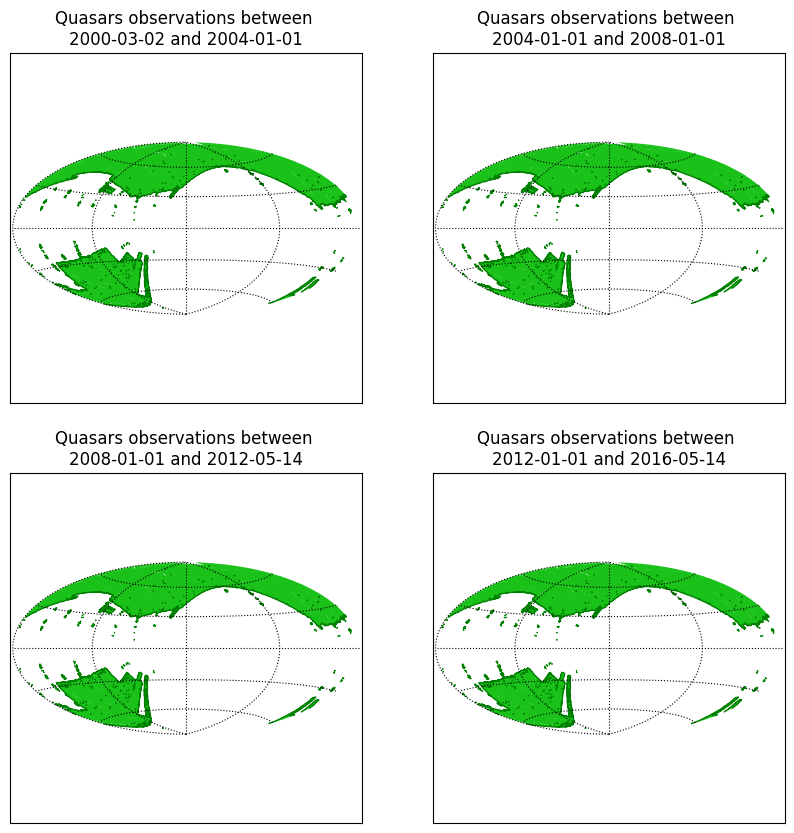

In [18]:
def add_to_plot(fig, id, wcs, title, moc):
    ax = fig.add_subplot(id, projection=wcs)

    ax.grid(color="black", linestyle="dotted")
    ax.set_title(title)
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')

    #Draw the MOC with its HEALPix cells
    moc.fill(ax=ax, wcs=wcs, alpha=0.9, fill=True, linewidth=0, color="#00bb00")
    #Draw the perimeter of a MOC
    moc.border(ax=ax, wcs=wcs, linewidth=1, color="green")

fig = plt.figure(figsize=(10, 10))

time_ranges = Time([
        [["2000-03-02", "2004-01-01"]],
        [["2004-01-01", "2008-01-01"]],
        [["2008-01-01", "2012-05-14"]],
        [["2012-01-01", "2016-05-14"]]
    ], format='iso', scale='tdb', out_subfmt="date")

with World2ScreenMPL(fig, 
         fov=330 * u.deg,
         center=SkyCoord(0, 0, unit='deg', frame='galactic'),
         coordsys="galactic",
         rotation=Angle(0, u.degree),
         projection="AIT") as wcs:

    for i in range(0, 4):
        moc_sdss = sdss.query_by_time(time_ranges[i])
        title = "Quasars observations between \n{0} and {1}".format(time_ranges[i][0, 0].iso, time_ranges[i][0, 1].iso)
        id_subplot = int("22" + str(i+1))
        add_to_plot(fig, id_subplot, wcs, title, moc_sdss)

plt.show()

## Compute the intersection between Space-Time coverages

#### Retrieve the areas that have been observed at the same time by two surveys

In [19]:
query = '''
SELECT  *  FROM tables 
WHERE description LIKE '%3XMM%'
'''

mash_catalogues = tap_vizier.search(query).to_table()
mash_catalogues

schema_name,table_name,table_type,description,utype,nrows
object,object,object,object,object,object
IX_HE,IX/47/3xmmeu,table,"Enhanced 3XMM catalogue (3XMMe), unique sources ( Rosen S.)",,219788
IX_HE,IX/50/xmm3r6s,table,"The 3XMM-DR6 Catalog, ""slim"" version ( Rosen S.R., Webb N. A., Watson, et al.)",,468440
IX_HE,IX/46/xmm3r5s,table,"The 3XMM-DR5 Catalog, ""slim"" version ( Rosen S.R., Webb N. A., Watson, et al.)",,396910
J_ApJ,J/ApJ/813/28/table4,table,"3XMM variable source classifications using the Random Forest machine learning algorithm (RF) ( Farrell S.A., Murphy T., Lo K.K.)",,2876
IX_HE,IX/48/xgustwra,table,"Allsky cross-matched 3XMMe catalogue ( Motch C., Carrera, F.J., Genova F., Jimenez-Esteban F., Lopez M., Michel L., Mingo B., Mints A., Nebot Gomez-Moran A., Pineau F.-X., Rosen S.R., Sanchez E. Schwope A., Solano E., Watson M.)",,162475
IX_HE,IX/54/xmm3r7s,table,"The 3XMM-DR7 Catalog, ""slim"" version ( Rosen S.R., Webb N.A., Watson, et al.)",,499266
IX_HE,IX/44/xmm3r4s,table,"The 3XMM-DR4 Catalog, ""slim"" version ( XMM-Newton Survey Science Centre Consortium)",,372728
IX_HE,IX/55/xmm3r8s,table,"The 3XMM-DR8 Catalog, ""slim"" version ( Rosen S.R., Webb N.A., Watson, et al.)",,531454


In [20]:
query = """SELECT 
RA_ICRS,DE_ICRS,MJD0
FROM "IX/55/xmm3r8s" """

table_xmm = tap_vizier.search(query).to_table()
table_xmm

RA_ICRS,DE_ICRS,MJD0
deg,deg,d
float64,float64,float32
44.970333,0.086244,55225.992
44.884839,0.164763,55225.992
44.910661,0.189424,55225.992
44.91994,0.215552,55225.992
44.885737,0.231606,55225.992
44.836183,0.236619,55225.992
44.809577,0.240032,55225.992
44.902356,0.240051,55225.992


In [21]:
times_xmm = Time(table_xmm['MJD0'].data, format='mjd', scale='tdb')
lon_xmm = table_xmm['RA_ICRS'].quantity
lat_xmm = table_xmm['DE_ICRS'].quantity

# Create the STMOC
xmm_dr8_stmoc = STMOC.from_times_positions(times_xmm, time_depth, lon_xmm, lat_xmm, spatial_depth)


In [22]:
# Compute their intersection and check that it is not empty
xmm_inter_sdss = xmm_dr8_stmoc.intersection(sdss)
assert(not xmm_inter_sdss.is_empty())

### - Discover all the functionalities on https://cds-astro.github.io/mocpy/ 

### - MOC data structure to plan multi-messenger observations 
- Greco et al., Astronomy and Computing 2021, DOI: [10.1016/j.ascom.2022.100547](https://ui.adsabs.harvard.edu/link_gateway/2022A&C....3900547G/doi:10.1016/j.ascom.2022.100547)
- Notebook: https://github.com/ggreco77/MOC-to-plan-MMA
